In [1]:
import sys, os, pprint
sys.path.append(os.path.abspath('../'))
import argparse, logging, sys
import ptp.reader
import ptp.ls
import ptp.metrics
import ptp.pktselection
import ptp.kalman
import ptp.frequency
import ptp.bias
import ptp.window
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
filename   = "../data/serial-20200116-215655.json"

In [3]:
reader = ptp.reader.Reader(filename)
reader.run()
print("Dataset info:")
pprint.pprint(reader.metadata)

Dataset info:
{'fh_traffic': {'bitrate': {'dl': 837120000.0, 'ul': 837120000.0},
                'fs': 7680000.0,
                'iq_size': 24,
                'n_rru_dl': 2,
                'n_rru_ul': 2,
                'n_spf': 64,
                'type': 'inline'},
 'hops': 4,
 'n_rru_ptp': 2,
 'oscillator': 'ocxo',
 'start_time': '2020-01-16 21:56:55',
 'sync_period': 0.25}


In [4]:
# Message period in nanoseconds
if (reader.metadata is not None and "sync_period" in reader.metadata):
    T_ns = reader.metadata["sync_period"]*1e9
else:
    T_ns = 1e9/4

In [5]:
# Compensate the bias of two-way time offset measurements prior to post-processing
bias = ptp.bias.Bias(reader.data)
corr = bias.calc_true_asymmetry(operator="raw")
bias.compensate(corr=corr, toffset_key="x_est")

In [6]:
# Raw frequency estimations (mostly for visualization)
freq_delta = 64
freq_estimator = ptp.frequency.Estimator(reader.data, delta=freq_delta)
freq_estimator.set_truth(delta=freq_delta)
freq_estimator.optimize_to_y()
freq_estimator.process()

# Time offset drift estimations through the PI control loop
damping, loopbw = freq_estimator.optimize_loop()
freq_estimator.loop(damping = damping, loopbw = loopbw)

Loop's settling time exceeds half the data length(damping: 0.707000, loopbw: 0.000100)
Skipping damping: 0.707000, loopbw: 0.000100


Tuned window lengths:
                  ls: 4096
      sample-average: 4096
         sample-ewma: 4096
       sample-median: 1024
          sample-min: 4096
          sample-max: 256
         sample-mode: 8192


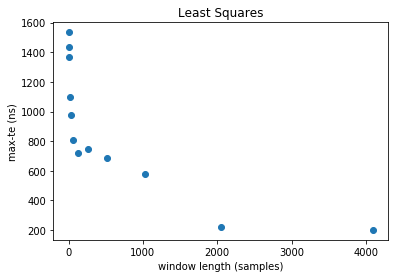

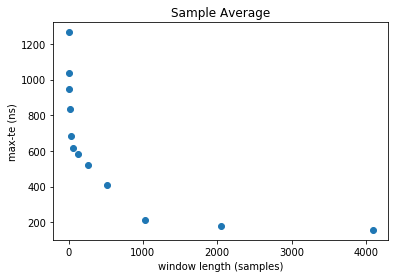

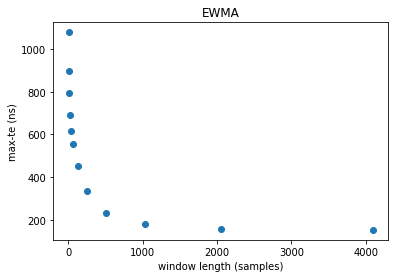

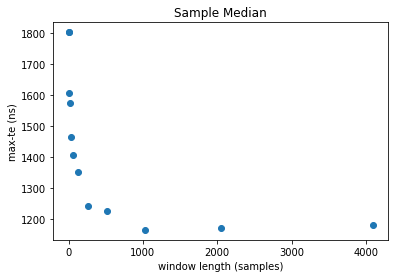

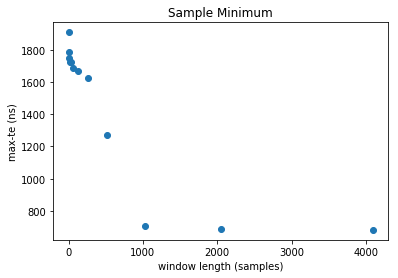

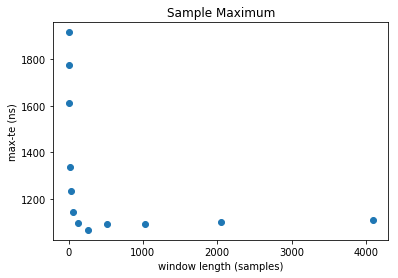

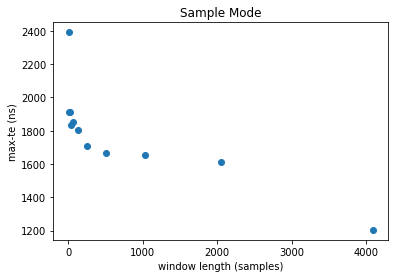

In [7]:
window_optimizer = ptp.window.Optimizer(reader.data, T_ns)
window_optimizer.process('all', file=filename,
                         plot=True, fine_pass=False, force=False)
window_optimizer.save()
est_op    = window_optimizer.est_op
N_ls      = est_op["ls"]["N_best"]             # LS
N_movavg  = est_op["sample-average"]["N_best"] # Moving average
N_median  = est_op["sample-median"]["N_best"]  # Sample-median
N_min     = est_op["sample-min"]["N_best"]     # Sample-minimum
N_max     = est_op["sample-max"]["N_best"]     # Sample-maximum
N_mode    = est_op["sample-mode"]["N_best"]    # Sample-mode
N_ewma    = est_op["sample-ewma"]["N_best"]    # EWMA

print("Tuned window lengths:")
for i in est_op:
    print("%20s: %d" %(i, est_op[i]["N_best"]))

In [8]:
# Least-squares estimator
ls = ptp.ls.Ls(N_ls, reader.data, T_ns)
ls.process("eff")

In [9]:
# Kalman
# kalman = ptp.kalman.Kalman(reader.data, T_ns/1e9)
kalman = ptp.kalman.Kalman(reader.data, T_ns/1e9,
                           trans_cov = [[1, 0], [0, 1e-2]],
                           obs_cov = [[1e4, 0], [0, 1e2]])
kalman.process()

In [10]:
pkts = ptp.pktselection.PktSelection(N_movavg, reader.data)

In [11]:
# Moving average
pkts.process("avg")

In [12]:
# Sample-median
pkts.set_window_len(N_median)
pkts.process("median")

In [13]:
# Sample-minimum
pkts.set_window_len(N_min)
pkts.process("min")

In [14]:
# Sample-maximum
pkts.set_window_len(N_max)
pkts.process("max")

In [15]:
# Exponentially weighted moving average
pkts.set_window_len(N_ewma)
pkts.process("ewma")

In [16]:
# Sample-mode
pkts.set_window_len(N_mode)
pkts.process("mode")

In [17]:
# Compensate bias of results produced by some packet selection operators
# Sample-median
corr_median = bias.calc_true_asymmetry(operator="median")
bias.compensate(corr=corr_median, toffset_key="x_pkts_median")

# Sample-minimum
corr_min = bias.calc_true_asymmetry(operator="min")
bias.compensate(corr=corr_min, toffset_key="x_pkts_min")

# Sample-maximum
corr_max = bias.calc_true_asymmetry(operator="max")
bias.compensate(corr=corr_max, toffset_key="x_pkts_max")

# Sample-mode
corr_mode = bias.calc_true_asymmetry(operator="mode")
bias.compensate(corr=corr_mode, toffset_key="x_pkts_mode")

In [18]:
# PTP analyser
analyser = ptp.metrics.Analyser(reader.data)

In [19]:
analyser.check_seq_id_gaps()

Checking sequenceIDs: OK (no gaps)


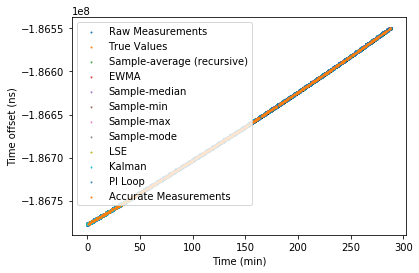

In [20]:
analyser.plot_toffset_vs_time(save=False)

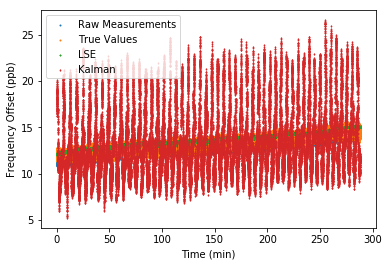

In [21]:
analyser.plot_foffset_vs_time(save=False)

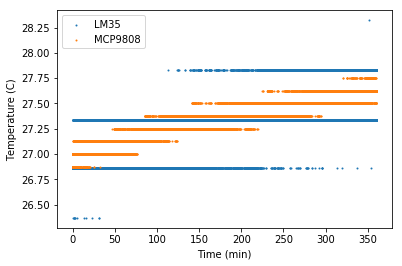

In [22]:
analyser.plot_temperature(save=False)

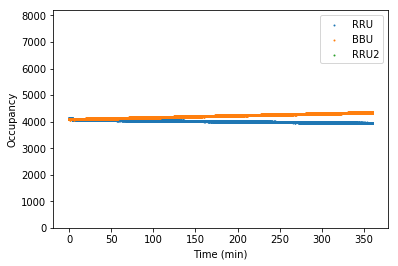

In [23]:
analyser.plot_occupancy(save=False)

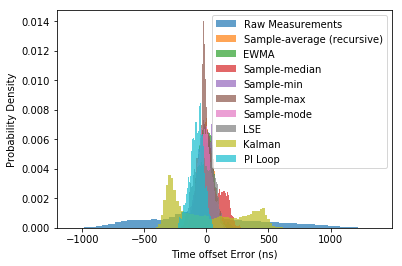

In [24]:
analyser.plot_toffset_err_hist(save=False)

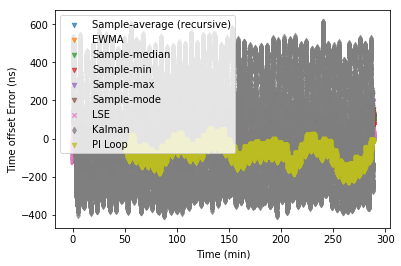

In [25]:
analyser.plot_toffset_err_vs_time(show_raw = False, save=False)

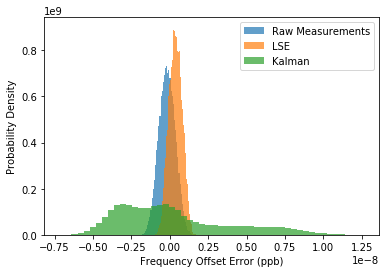

In [26]:
analyser.plot_foffset_err_hist(save=False)

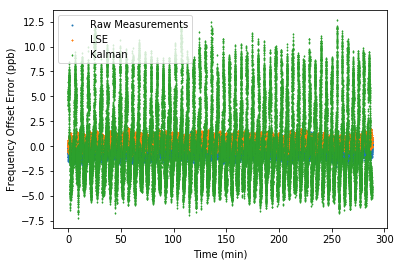

In [27]:
analyser.plot_foffset_err_vs_time(save=False)

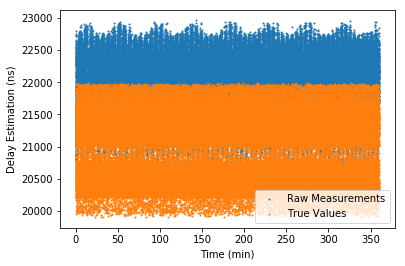

In [28]:
analyser.plot_delay_vs_time(save=False)

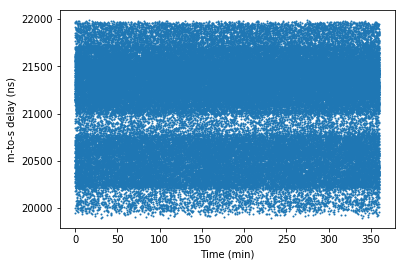

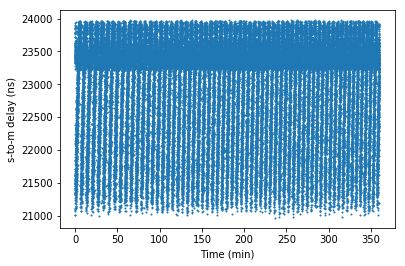

In [29]:
analyser.plot_delay_vs_time(split=True, save=False)

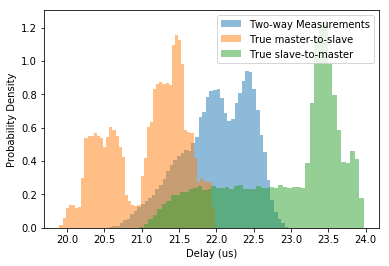

In [30]:
analyser.plot_delay_hist(n_bins=50, save=False)

/home/camila/.virtualenvs/ptp/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


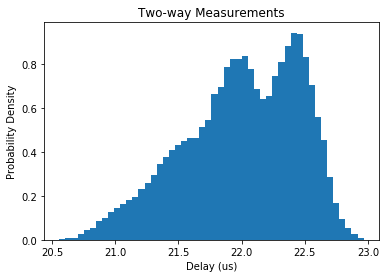

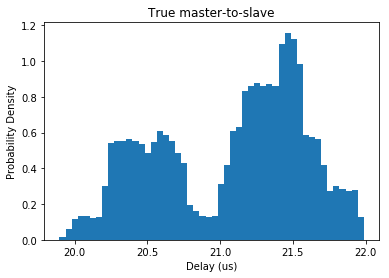

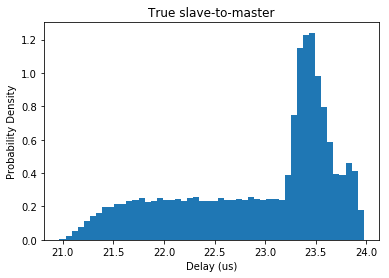

In [31]:
analyser.plot_delay_hist(split=True, n_bins=50, save=False)

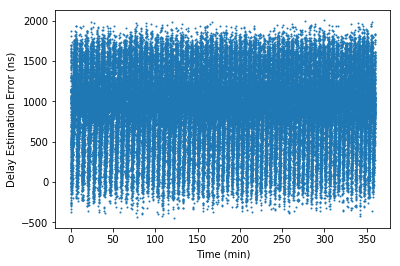

In [32]:
analyser.plot_delay_est_err_vs_time(save=False)

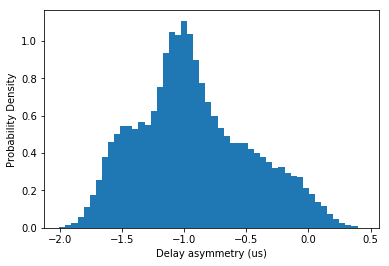

In [33]:
analyser.plot_delay_asym_hist(n_bins=50, save=False)

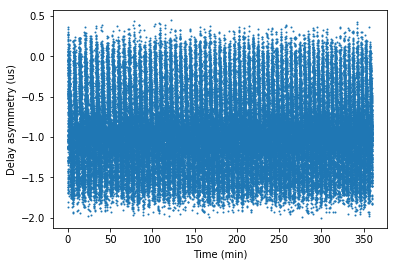

In [34]:
analyser.plot_delay_asym_vs_time(save=False)

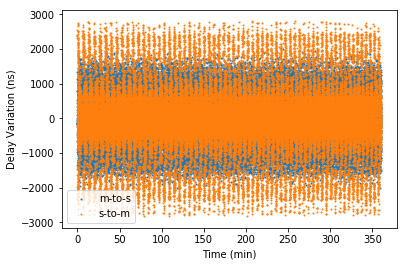

In [35]:
analyser.plot_pdv_vs_time(save=False)

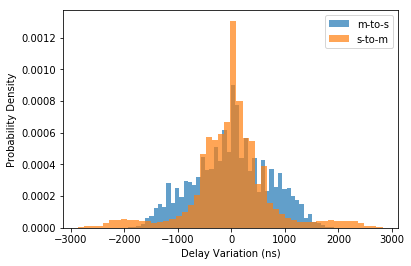

In [36]:
analyser.plot_pdv_hist(save=False)

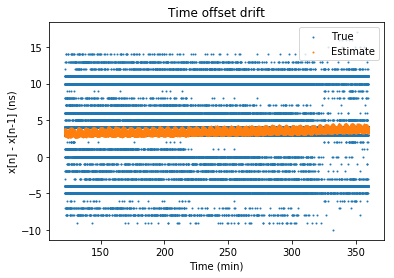

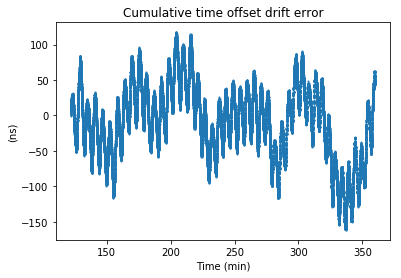

In [37]:
analyser.plot_toffset_drift_vs_time(save=False)

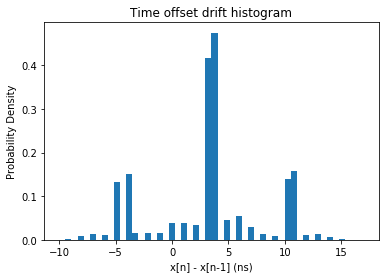

In [38]:
analyser.plot_toffset_drift_hist(save=False)

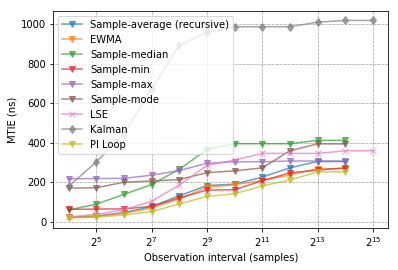

In [39]:
analyser.plot_mtie(show_raw = False, save=False)

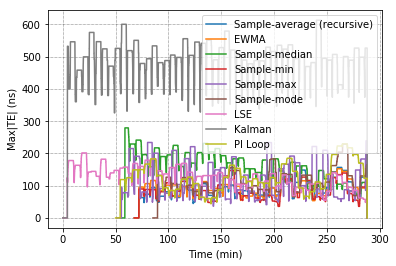

In [40]:
analyser.plot_max_te(show_raw=False, window_len = 1000, save=False)

In [41]:
analyser.ptp_exchanges_per_sec(save=False)

Average no. of PTP exchanges per second: 3.865624


3.8656242552382687

In [42]:
analyser.delay_asymmetry(save=False)


Delay asymmetry analysis:

Metric 	      m-to-s	      s-to-m	   asymmetry
Average	 21078.66 ns	 22922.64 ns	  -921.99 ns
Std Dev	   504.15 ns	   759.17 ns	   455.21 ns
Minimum	 19896.00 ns	 20966.00 ns	  -535.00 ns
Maximum	 21987.00 ns	 23975.00 ns	  -994.00 ns
Median	 21212.00 ns	 23276.00 ns	 -1032.00 ns
Mode	 21437.00 ns	 23367.00 ns	  -965.00 ns


-921.991160406286

In [43]:
analyser.toffset_err_stats(save=False)


Time offset estimation error statistics:

x_est                 Mean:   -1.860 ns  Sdev:  455.767 ns  RMS:   455.771 ns
x_pkts_avg_recursive  Mean:   -4.729 ns  Sdev:   53.641 ns  RMS:    53.849 ns
x_pkts_ewma           Mean:   -6.497 ns  Sdev:   54.804 ns  RMS:    55.187 ns
x_pkts_median         Mean:   29.289 ns  Sdev:   88.470 ns  RMS:    93.192 ns
x_pkts_min            Mean:  -10.035 ns  Sdev:   53.100 ns  RMS:    54.039 ns
x_pkts_max            Mean:   10.834 ns  Sdev:   47.273 ns  RMS:    48.499 ns
x_pkts_mode           Mean:  -17.757 ns  Sdev:   57.621 ns  RMS:    60.295 ns
x_ls_eff              Mean:  -18.443 ns  Sdev:   72.717 ns  RMS:    75.019 ns
x_kf                  Mean:   -5.964 ns  Sdev:  282.075 ns  RMS:   282.138 ns
x_loop                Mean:  -77.521 ns  Sdev:   53.101 ns  RMS:    93.964 ns


In [44]:
analyser.foffset_err_stats(save=False)


Frequency offset estimation error statistics:

y_est                 Mean:   -0.174 ppb  Sdev:    0.526 ppb  RMS:     0.554 ppb
y_ls_eff              Mean:    0.355 ppb  Sdev:    0.775 ppb  RMS:     0.852 ppb
y_kf                  Mean:  -38.628 ppb  Sdev:  813.962 ppb  RMS:   814.878 ppb


In [45]:
analyser.toffset_drift_err_stats(save=False)


Time offset drift estimation error statistics:

Drift                 Mean:    0.001 ns  Sdev:    4.839 ns  RMS:     4.839 ns
Cumulative Drift      Mean:   -9.602 ns  Sdev:   53.034 ns  RMS:    53.897 ns


In [46]:
analyser.ranking(metric="max-te", save=False)


Performance ranking based on max-te:

x_pkts_min           Mean:   86.416 ns
x_pkts_avg_recursive Mean:   87.993 ns
x_pkts_ewma          Mean:   91.889 ns
x_pkts_mode          Mean:  113.993 ns
x_loop               Mean:  114.353 ns
x_ls_eff             Mean:  123.387 ns
x_pkts_max           Mean:  128.100 ns
x_pkts_median        Mean:  169.252 ns
x_kf                 Mean:  487.685 ns
x_est                Mean:  1190.740 ns


In [47]:
analyser.ranking(metric="mtie", save=False)


Performance ranking based on mtie:

x_loop               Mean:  119.510 ns
x_pkts_ewma          Mean:  147.053 ns
x_pkts_min           Mean:  155.077 ns
x_pkts_avg_recursive Mean:  160.071 ns
x_ls_eff             Mean:  211.879 ns
x_pkts_mode          Mean:  262.742 ns
x_pkts_max           Mean:  270.713 ns
x_pkts_median        Mean:  283.286 ns
x_kf                 Mean:  765.529 ns
x_est                Mean:  2324.455 ns


In [48]:
analyser.ranking(metric="rms", save=False)


Performance ranking based on rms:

x_pkts_max           Mean:   48.849 ns
x_pkts_avg_recursive Mean:   52.739 ns
x_pkts_min           Mean:   54.441 ns
x_pkts_ewma          Mean:   55.280 ns
x_pkts_mode          Mean:   60.295 ns
x_ls_eff             Mean:   72.933 ns
x_loop               Mean:   79.890 ns
x_pkts_median        Mean:   97.871 ns
x_kf                 Mean:  281.051 ns
x_est                Mean:  453.571 ns


In [49]:
analyser.ranking(metric="std", save=False)


Performance ranking based on std:

x_loop               Mean:   44.802 ns
x_pkts_max           Mean:   47.546 ns
x_pkts_avg_recursive Mean:   52.213 ns
x_pkts_min           Mean:   52.843 ns
x_pkts_ewma          Mean:   54.736 ns
x_pkts_mode          Mean:   57.621 ns
x_ls_eff             Mean:   71.619 ns
x_pkts_median        Mean:   92.035 ns
x_kf                 Mean:  281.010 ns
x_est                Mean:  453.570 ns
